# Natural Language Processing (NLP) Project - Bag of Words Embedding in Tensorflow

# Use bag-of-words technique with a SMS database to predict text classification as spam or ham (not spam) by applying stochastic training to a logistics regression model algorithm

In [1]:
"""import numpy, tensorflow, and matplotlib.pyplot modules"""

import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow.python.framework import ops

C:\Users\trevo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
""" Download or read in text data """

# Establish and initialize text data, texts, and target lists
text_data = []
texts = []
target = []

# Define file root location where the jupyter program file is located
data_root = '.'
save_file_name = os.path.join(data_root,'temp_spam_data.csv')
if (os.path.isfile(save_file_name)):
    print('SMS text dataset already loaded')
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        text_data = list(reader)
        # Remove empty lists
        text_data = [x for x in text_data if x != []]
else:
    print('Loading SMS text dataset')
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # Write text data to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x=='spam' else 0 for x in target]

SMS text dataset already loaded


In [3]:
"""pre-process the text data for building the bag-of-words vocabulary"""

# Convert all letters to lower case
texts = [x.lower() for x in texts]

# Remove all punctuations
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove all number characters
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Remove and time extra whitespace
texts = [' '.join(x.split()) for x in texts]

In [4]:
"""Establish bag-of-words vocabulary from pre-processed text data"""

# Declare sentence size
sentence_size = 25

# Declare minimun word frequency
min_word_freq = 3

vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)
vocab_processor.fit_transform(texts)

# Determine size of bag-of-word vocabulary
embedding_size = len(vocab_processor.vocabulary_)

In [5]:
"""Establish 80%/20% training and validation datasets,respectively"""

# Generate random indices from 80% of texts messages to establish the training dataset
train_indices = np.random.choice(len(texts), round((0.8*len(texts))), replace=False)

# Generate test data from the remaining text message indices
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))

# Generate text message training dataset list
texts_train_list = [x for ix, x in enumerate(texts) if ix in train_indices]

# Generate text message validation dataset list
texts_test_list = [x for ix, x in enumerate(texts) if ix in test_indices]

# Generate text message target classifications for training dataset list
target_train_list = [x for ix, x in enumerate(target) if ix in train_indices]

# Generate text message target classifications for validation dataset list
target_test_list = [x for ix, x in enumerate(target) if ix in test_indices]

In [6]:
"""Establish graph session variables and placeholders; and text message sentence vector """

# Declare algorithm weight variables and initialize with random values based on the size of the bag-of-words vocabulary
A = tf.Variable(tf.random_normal(shape = [embedding_size,1]))

# Declare algorithm bias variable and initialize with a random value
b = tf.Variable(tf.random_normal(shape = [1,1]))

# Declare feature data placeholder
x_data = tf.placeholder(shape = [sentence_size], dtype=tf.int32)

# Declare classification target placeholder
y_target = tf.placeholder(shape = [1,1], dtype=tf.float32)

# Establish embedding matrix for bag-of-words 

# Define identity matrix based on the number of commom words in the text messages  
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Encode text message sentence words
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)

# Generate text message sentence vector
x_col_sums = tf.reduce_sum(x_embed,0)

# Establish 2D sentence vector
x_col_sums_2D = tf.expand_dims(x_col_sums,0)

In [7]:
"""Define the training model algorithm"""

# Establish learning rate
learning_rate = 0.001

model_output = tf.add(tf.matmul(x_col_sums_2D,A), b)

# Define loss function

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = model_output))

# Define optimizer function

my_opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_step = my_opt.minimize(loss)

# Prediction Function
prediction = tf.sigmoid(model_output)

In [10]:
"""Establish graph session for stochastic training of the natural language processing (NLP)"""

# logistic regression model algorithm

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


# Define loss and training accuracy lists variables
loss_vec_list = []
train_acc_all_list = []
train_acc_avg_list = []

print('Train Model Over {} Sentences'.format(len(texts_train_list)))

# loop for graph training session
for ix, t in enumerate(vocab_processor.fit_transform(texts_train_list)):
    # Establish training target data for session placeholder
    y_data = [[target_train_list[ix]]]
    # Run stochastic graph training session
    sess.run(train_step, feed_dict = {x_data:t, y_target:y_data})
    # Run graph session to determine loss function for each generation
    temp_loss = sess.run(loss, feed_dict = {x_data:t, y_target:y_data})
    # Save generation loss value in list
    loss_vec_list.append(temp_loss)
    # Make single prediction
    [[temp_pred]] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    train_acc_temp = target_train_list[ix]==np.round(temp_pred)
    train_acc_all_list.append(train_acc_temp)
    # Keeep trailing average of past 50 accuracy observations
    if (len(train_acc_all_list) >= 50):
        train_acc_avg_list.append(np.mean(train_acc_all_list[-50:]))
    # Display training outcome results from each 100 set of generation
    if ((ix+1)%100 == 0):
        print('Training Observation #{} Loss = {}'.format((ix+1), temp_loss))
        
            
# Display training accuracy results
print('Overall Training Accuracy: {}'.format(np.mean(train_acc_all_list)))

Train Model Over 4459 Sentences
Training Observation #100 Loss = 5.7771472938839e-07
Training Observation #200 Loss = 2.19277414004182e-08
Training Observation #300 Loss = 6.239854883460794e-06
Training Observation #400 Loss = 5.667752702720463e-07
Training Observation #500 Loss = 0.0010353293037042022
Training Observation #600 Loss = 1.2404851986502763e-05
Training Observation #700 Loss = 5.1569870265666395e-05
Training Observation #800 Loss = 2.9950408134027384e-05
Training Observation #900 Loss = 0.08134123682975769
Training Observation #1000 Loss = 0.00811486504971981
Training Observation #1100 Loss = 0.058279234915971756
Training Observation #1200 Loss = 0.15897028148174286
Training Observation #1300 Loss = 2.7951018810272217
Training Observation #1400 Loss = 5.039605617523193
Training Observation #1500 Loss = 0.01422325149178505
Training Observation #1600 Loss = 1.2228758335113525
Training Observation #1700 Loss = 0.16479609906673431
Training Observation #1800 Loss = 4.1254890675

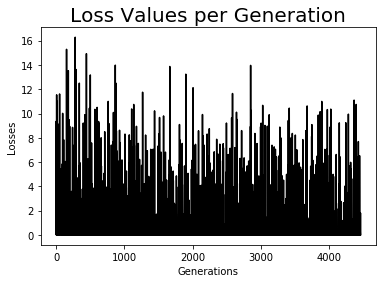

In [11]:
"""Visualize model loss values"""

#Plot Losses
plt.plot(loss_vec_list, 'k-')
plt.title('Loss Values per Generation', fontsize = 20)
plt.xlabel('Generations')
plt.ylabel('Losses')
plt.show()

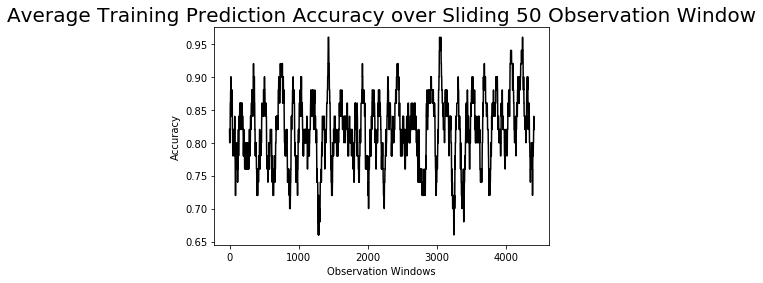

In [12]:
"""Visualize training prediction accurary"""

#Plot Losses
plt.plot(train_acc_avg_list, 'k-')
plt.title('Average Training Prediction Accuracy over Sliding 50 Observation Window', fontsize = 20)
plt.xlabel('Observation Windows')
plt.ylabel('Accuracy')
plt.show()

In [13]:
"""Establish graph session for NLP logistic regression model validation testing"""

# Define validation accuracy lists variable
test_acc_all_list = []

print('Validation Testings Over {} Sentences'.format(len(texts_test_list)))

# loop graph session for NLP logistic regression model validation testing
for ix, t in enumerate(vocab_processor.fit_transform(texts_test_list)):
    # Establish test target data for session placeholder
    y_data = [[target_test_list[ix]]]
    # Make single prediction
    [[temp_pred]] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    test_acc_temp = target_test_list[ix]==np.round(temp_pred)
    test_acc_all_list.append(test_acc_temp)
  
            
# Display validation accuracy results
print('Overall Validation Accuracy: {}'.format(np.mean(test_acc_all_list)))

Validation Testings Over 1115 Sentences
Overall Validation Accuracy: 0.8080717488789237
